# Autoencoder

自编码器是一类无监督的学习方法，可以将输入数据压缩为低维的隐向量表示。它包含两部分网络结构，即编码器和解码器。编码器将输入数据压缩为隐向量，解码器尝试将隐向量重建为对应的数据。通过最小化解码器输出和输入数据之间的差异，编码器可以学习到输入数据的压缩表示。

设输入空间为$x\in \mathcal X\subseteq\mathbb R^m$，隐向量空间$z\in \mathbb R^n$，编码器$G: R^m\rightarrow R^n$，解码器$D: R^n\rightarrow R^m$。$d(x, x')$为定义在$\mathbb R^m$上的差异度量（范数，或其他能够反映$x, x'$差异的函数）。自编码器的训练目标可以表示为：

$$
L(\theta_G, \theta_D) = \mathbb E_{x} [d(x, D_{\theta_D}(E_{\theta_E}(x)))]
$$

通常情况下，$n < m$。否则，往往会学习到平凡的编码器表示。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# SVG output
%config InlineBackend.figure_format = 'svg'

# Fix for certificate error
# https://stackoverflow.com/questions/71263622
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

导入MNIST数据集

In [2]:
train_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)

定义编码器结构，编码器将输入映射到低维空间中

In [3]:
import itertools
from typing import List

class Encoder(torch.nn.Module):
    def __init__(self, dim_layers: List[int]):
        super().__init__()
        dim_layers = [784, *dim_layers]
        self.layers = torch.nn.Sequential(*[
            torch.nn.Sequential(
                torch.nn.Linear(in_dim, out_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.2),
            )
            for in_dim, out_dim in itertools.pairwise(dim_layers)
        ])

    def forward(self, x: torch.Tensor):
        x = x.reshape(-1, 784)
        return self.layers(x)

解码器重新将低维数据映射回高维空间

In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, dim_layers: List[int]):
        super().__init__()
        dim_layers = [*dim_layers, 784]
        self.layers = torch.nn.Sequential(*[
            torch.nn.Sequential(
                torch.nn.Linear(in_dim, out_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.2)
            )
            for in_dim, out_dim in itertools.pairwise(dim_layers)
        ], *[torch.nn.Tanh()])

    def forward(self, x: torch.Tensor):
        return self.layers(x).reshape(-1, 28, 28) * 0.5 + 0.5

class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder_layers: List[int], decoder_layers: List[int]):
        super().__init__()
        self.encoder = Encoder(encoder_layers)
        self.decoder = Decoder(decoder_layers)
        self.loss = torch.nn.MSELoss(reduction='none')
        self.device = torch.device('cpu')

    def to(self, *args, **kwargs):
        if args:
            self.device = args[0]
        elif 'device' in kwargs:
            self.device = kwargs['device']
        super().to(*args, **kwargs)

    def predict(self, x: torch.Tensor):
        x = x.to(self.device)
        x_fake = self.decoder(self.encoder(x))
        return x_fake

    def forward(self, x: torch.Tensor):
        x = x.to(self.device)
        x_fake = self.predict(x)
        x_real = x.reshape(-1, 28, 28)
        return self.loss(x_fake, x_real)

model = AutoEncoder(
    [512, 512, 256, 128, 64],
    [64, 128, 256, 512, 512]
)

从测试集中选出10个数字的图片

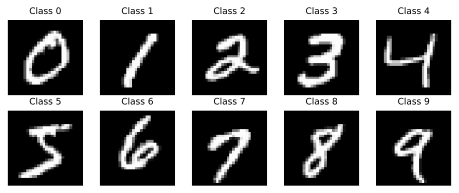

In [5]:
from matplotlib.axes import Axes
from matplotlib import pyplot as plt
from typing import Optional

test_input = {}
for (x, y) in test_loader:
    if len(test_input) == 10:
        break
    size = y.size(0)
    for _ in range(size):
        if y[_].item() in test_input:
            continue
        test_input[y[_].item()] = x[_].detach()

def plot_image(x: torch.Tensor, ax: Optional[Axes] = None):
    img = x.view(28, 28).cpu().numpy()

    if ax is None:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(img, cmap='gray')
        ax.axis('off')


fig, ax = plt.subplots(2, 5, figsize=(8, 3))
axes = ax.flatten()
for i, ax in enumerate(axes):
    ax.set_title(f'Class {i}', fontsize=9)
    plot_image(test_input[i], ax)
plt.show()

训练过程的超参数如下：

In [6]:
N = 120
K = 1 # Evaluate loss on test after K epochs
K_plot = 10 # Plot sample after K epochs
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
device = 'cuda:5' if torch.cuda.is_available() else 'cpu'  # CUDA
model.to(device)

# Record training metrics
step = 0
train_metrics = []

训练过程中，每隔若干epoch输出一次自编码器对10个数字的输出。

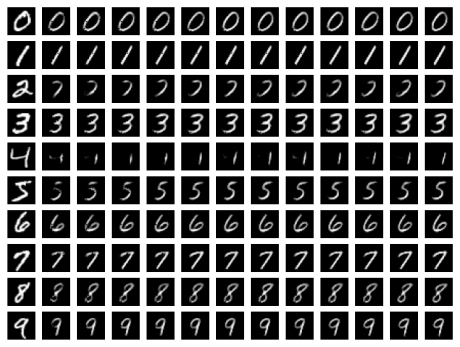

In [7]:
from typing import Dict, Iterator

fig, ax = plt.subplots(10, N // K_plot + 1, figsize=(8, 6))
axes = iter(ax.T)

def plot_column(axes: Iterator[List[Axes]], samples: Dict[int, torch.Tensor]):
    ax_column = next(axes)
    for i, x_sample in samples.items():
        plot_image(x_sample, ax_column[i])


plot_column(axes, test_input)

for epoch in range(N):
    step_metric = {}

    if (epoch + 1) % K == 0:
        model.eval()
        eval_loss, size = 0.0, 0
        for x_test, _ in test_loader:
            loss = model(x_test)
            eval_loss += loss.sum().item()
            size += loss.size(0)
        step_metric['eval_loss'] = eval_loss / size

    for x, _ in train_loader:
        model.train()
        step += 1
        optimizer.zero_grad()
        loss = model(x).mean()
        step_metric['loss'] = loss.item()
        loss.backward()
        optimizer.step()

        train_metrics.append(step_metric)
        step_metric = {}

    if (epoch + 1) % K_plot == 0:
        model.eval()
        decoder_output = {
            i: model.predict(x_sample).detach()
            for i, x_sample in test_input.items()
        }
        plot_column(axes, decoder_output)

fig.show()

In [8]:
from typing import Any, Dict, Iterable, List, Tuple
import random

def extract_metrics(data: List[Dict[str, Any]], field: str) -> Tuple[List[int], List[Any]]:
    x, y = [], []
    for step, record in enumerate(data, start=1):
        if field in record:
            x.append(step)
            y.append(record[field])
    return x, y

def ema(x, beta):
    y = x[0]
    for _ in x:
        y = beta * y + (1 - beta) * _
        yield y

def sample(x: Iterable[Any], y: Iterable[Any], ratio: float):
    result_x, result_y = [], []
    for x_sample, y_sample in zip(x, y):
        if random.random() < ratio:
            result_x.append(x_sample)
            result_y.append(y_sample)
    return result_x, result_y

绘制训练过程中的损失函数变化。

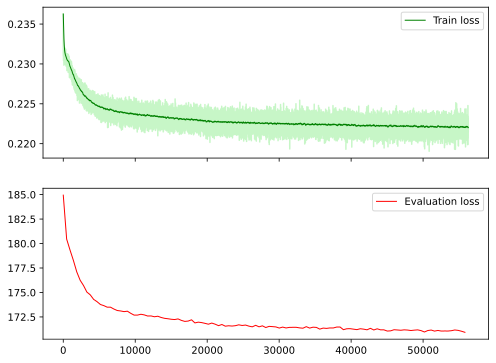

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

x_train_loss, y_train_loss = extract_metrics(train_metrics, 'loss')
x_eval_loss, y_eval_loss = extract_metrics(train_metrics, 'eval_loss')

ax1.plot(x_train_loss, y_train_loss, color='lightgreen', alpha=0.5)

ax1.plot(x_train_loss, [*ema(y_train_loss, 0.99)], label='Train loss', color='green', linewidth=1)
ax2.plot(x_eval_loss, y_eval_loss, label='Evaluation loss', color='red', linewidth=1)


ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

fig.show()